In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.stats import mode
from matplotlib import pyplot as plt
import seaborn as sns
from palettable.cartocolors.sequential import SunsetDark_6_r

## Data Validation

In [2]:
# change font sizes and whatnot
plt.rc("text", usetex=False)
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)

In [17]:
chains = np.load("cnn/1-cyanonaphthalene/chain.npy")
# hurr = np.load("cnn/2-cyanonapthalene/third.npy")

# chains = np.concatenate([hurr, chains], axis=0)

chains.shape

# Take the last 1000 samples of each walker, and then flatten
# along the walker dimension; i.e. get samples for each parameter
chains = chains[-1000:,:,:].reshape(-1, 14)

# calculate the percentiles used throughout the paper
summary_stats = np.percentile(chains, [16, 50, 84], 0)

# 16th, 50th, and 84th percentile
summary_stats.shape

_ = np.random.seed(42)

In [18]:
# plt.plot(chains[-1000:,:,9])

In [19]:
summary_stats

array([[9.17337409e+01, 7.16091682e+01, 2.32697839e+02, 2.47602596e+02,
        1.88675327e+11, 3.08430134e+11, 9.56122466e+10, 2.65632114e+11,
        6.03295142e+00, 5.57392696e+00, 5.76441794e+00, 5.89097114e+00,
        6.01529037e+00, 1.25748843e-01],
       [9.17784473e+01, 7.16571955e+01, 2.32741376e+02, 2.47641861e+02,
        2.15451312e+11, 3.38557119e+11, 1.24346941e+11, 2.91733983e+11,
        6.03338100e+00, 5.57609269e+00, 5.76656913e+00, 5.89322623e+00,
        6.01742744e+00, 1.26017676e-01],
       [9.18232926e+01, 7.17052586e+01, 2.32785265e+02, 2.47685415e+02,
        2.43781590e+11, 3.69760786e+11, 1.51331246e+11, 3.18585687e+11,
        6.03382461e+00, 5.57822134e+00, 5.76872840e+00, 5.89546950e+00,
        6.01947428e+00, 1.26289768e-01]])

In [20]:
# column names for each parameter
param_names = [
    r'Source Size #1 ["]',
    r'Source Size #2 ["]',
    r'Source Size #3 ["]',
    r'Source Size #4 ["]',
    r'N$_\mathrm{col}$ #1 [$10^{11}$ cm$^{-2}$]',
    r'N$_\mathrm{col}$ #2 [$10^{11}$ cm$^{-2}$]',
    r'N$_\mathrm{col}$ #3 [$10^{11}$ cm$^{-2}$]',
    r'N$_\mathrm{col}$ #4 [$10^{11}$ cm$^{-2}$]',
    r'T$_\mathrm{ex}$ [K]',
    r'V$_\mathrm{LSRK}$ #1 [km s$^{-1}$]',
    r'V$_\mathrm{LSRK}$ #2 [km s$^{-1}$]',
    r'V$_\mathrm{LSRK}$ #3 [km s$^{-1}$]',
    r'V$_\mathrm{LSRK}$ #4 [km s$^{-1}$]',
    r'dV [km s$^{-1}$]'
]

In [21]:
df = pd.DataFrame(
    chains,
    columns=param_names
)

# hacker statistics (not really)
# we don't need to use the full 20k samples to make plots, just take 1000 samples
# from the "posterior"
samples = df.sample(1000, replace=True)

# For the column densities, bring the numbers down to help make the figure formatting
# nicer looking
for i in range(4, 8):
    samples[param_names[i]] /= 1e11

In [22]:
top_color, bottom_color = SunsetDark_6_r.hex_colors[0], SunsetDark_6_r.hex_colors[-1]

/home/kelvin/anaconda3/envs/astro_mcmc/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


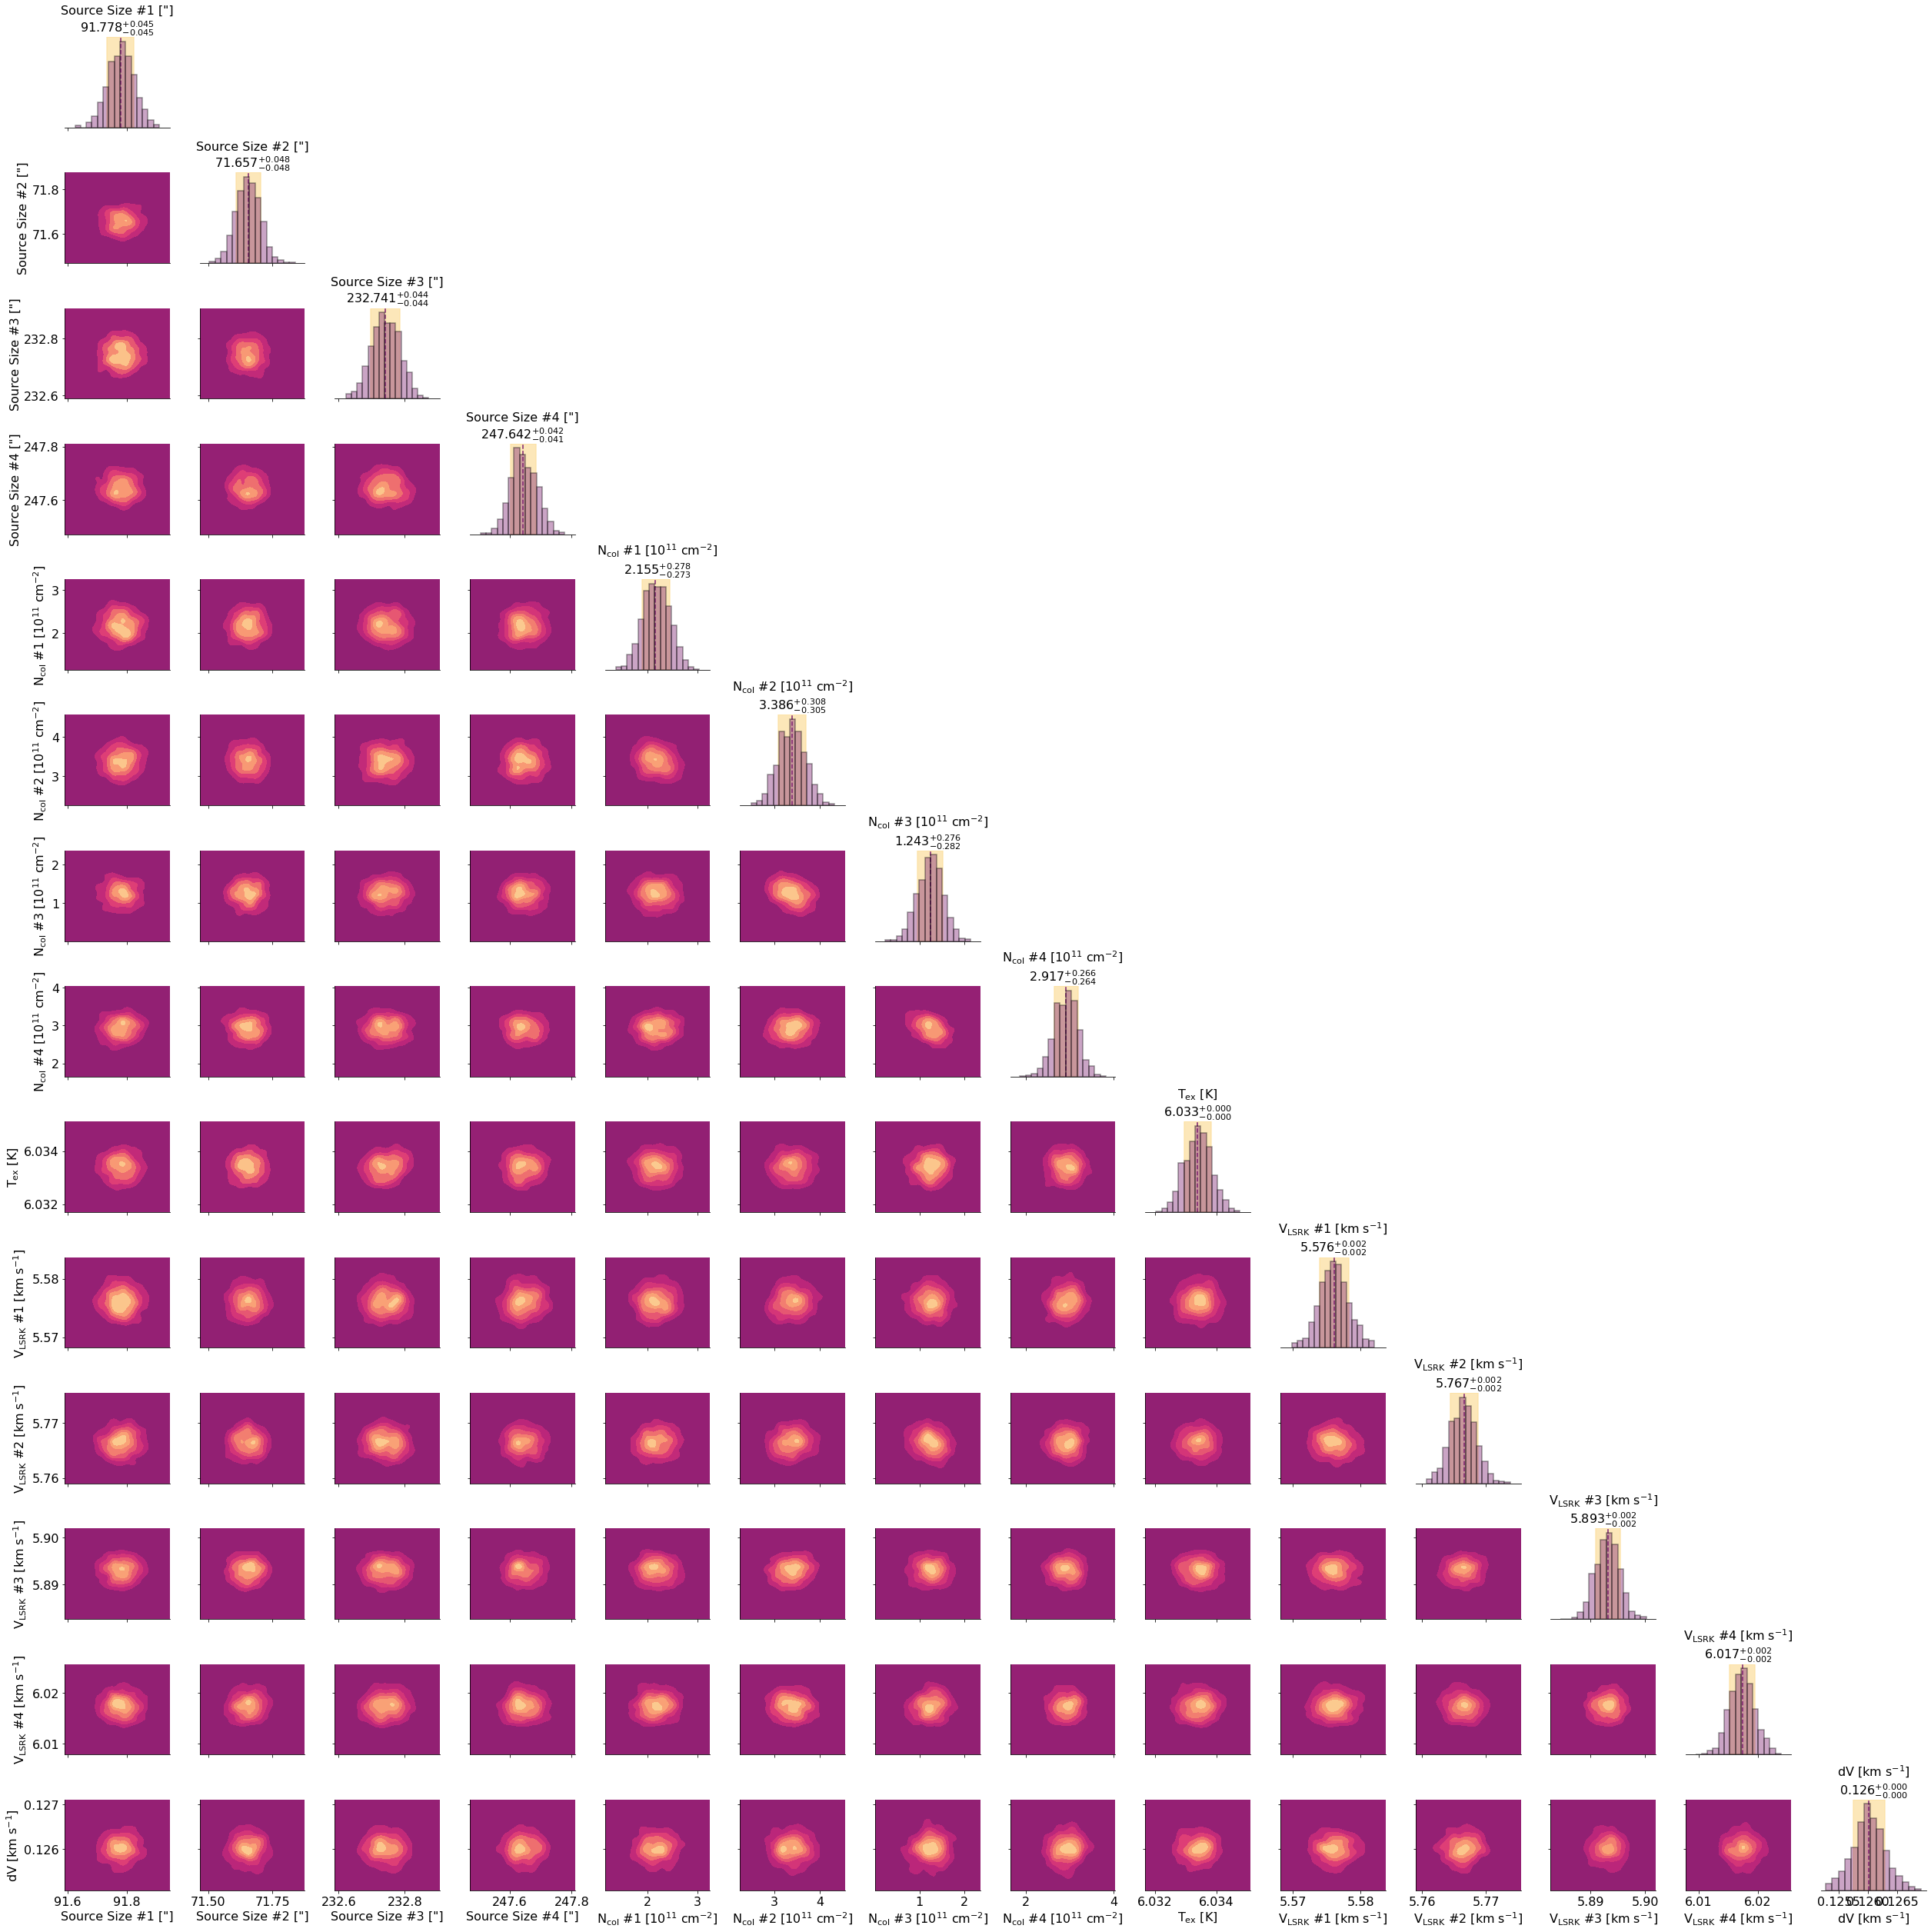

In [23]:
grid = sns.PairGrid(samples, corner=True, diag_sharey=False)
# grid.map_diag(sns.distplot, kde=False, color=top_color, norm_hist=True)# cumulative=False)
grid.map_diag(plt.hist, bins=15, color=top_color, linewidth=1.5, edgecolor="k", alpha=0.4, zorder=10)
grid.map_lower(sns.kdeplot, shade=True, shade_lowest=True, cmap=SunsetDark_6_r.get_mpl_colormap(), n_levels=6)
# loop over the diagonal of the corner plot, which are CDFs. We want to annotate
# the percentiles in this plot
for index, ax in enumerate(grid.diag_axes):
    name = param_names[index]
    param_stats = np.copy(summary_stats[:,index])
    if index in [4, 5, 6, 7]:
        param_stats /= 1e11
    # draw the region comprising 16th to 84th percentiles
    ax.axvspan(
        min(param_stats),
        max(param_stats),
        lw=1.5,
        color=bottom_color,
        facecolor="k",
        alpha=0.7,
        zorder=2
    )
    ranges = param_stats - param_stats.mean()
    ax.axvline(param_stats[1], lw=1.5, ls="--", color=top_color)
    # format the percentile stats in the title. This is somewhat of a pain because
    # we are combining LaTeX strings with Python f-strings
    lower_text = r"_\mathrm{" + f"{ranges[0]:.3f}" + r"}"
    upper_text = r"^\mathrm{" + f"+{ranges[-1]:.3f}" + r"}$"
    middle_text = f"{param_stats[1]:.3f}"
    ax.set_title(
        f"{name}\n" + r"$" + middle_text + lower_text + upper_text, fontsize=16
    )
# for i in range(1, 3):
#     grid.axes[i][0].set_ylim([0., 400.])
#     grid.axes[-1][i].set_xlim([0., 400.])
# for i in range(4, 8):
#     grid.axes[-1][i].set_xlim([1., 7.])
#     grid.axes[i][0].set_ylim([1., 7.])

grid.fig.tight_layout()

In [17]:
grid.fig.savefig("2-cnn_corner.pdf", dpi=300, transparent=True)